# AB Testing Course - PA James

## 0.1 Imposts

In [52]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats import api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp,shapiro,ttest_ind,mannwhitneyu,f_oneway
import seaborn as sns

# 1.0 Load Data

In [2]:
df_raw = pd.read_csv('../data/ab_data.csv')

In [3]:
df_raw.shape

(294478, 5)

In [4]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# 2.0 Design de Experimentos

## 2.1 Formação das Hipóteses

## 2.2 Parâmetros do experimentos

In [5]:
#nível de confiança
confidence_level = 0.95

#nível de significancia
significance_level = 1 - confidence_level

#conversões da página atual e da nova página
p1 = 0.13 #atual
p2 = 0.15 #novo

#tamanho do efeito
effect_size = sms.proportion_effectsize(p1,p2)

#poder estatístico
power = 0.8

In [6]:
#sample size - Tamanho da amostra
sample_n = sms.NormalIndPower().solve_power(
  effect_size,
  power=power,
  alpha=significance_level
)

sample_n = math.ceil(sample_n)
print(f'O tamanho da amostra do grupo controle é de {sample_n}.')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n}.')
print(f'O tamanho total da amostra é de {sample_n*2}.')

O tamanho da amostra do grupo controle é de 4720.
O tamanho da amostra do grupo de tratamento é de 4720.
O tamanho total da amostra é de 9440.


In [7]:
conversion_rate = 0.1
x = sample_n/conversion_rate

print(f'O número de emails para enviar é de {math.ceil(x)} para cada grupo')
print(f'O número total de emails para enviar é de {math.ceil(x*2)}')

O número de emails para enviar é de 47200 para cada grupo
O número total de emails para enviar é de 94400


In [9]:
# 3.0 Análise descritiva dos dados
print(f'Number of rows: {df_raw.shape[0]}')
print(f'Number of coljmns: {df_raw.shape[1]}')

Number of rows: 294478
Number of coljmns: 5


In [10]:
# 3.1 Verificação dos dados faltantes
df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [16]:
# 3.2 Conferir as 'flags'
df_raw.loc[:,['user_id', 'group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [18]:
# 3.3 Quantos usurários estão em mais de um grupo?
df_raw.loc[:,['user_id', 'group']].groupby('user_id').count().sort_values(by = 'group',ascending=False).reset_index().query('group > 1')

,user_id,group
0,729669,2
1,825266,2
2,663033,2
3,674959,2
4,875210,2
...,...,...
3889,800469,2
3890,738614,2
3891,651850,2
3892,720460,2


Vamos deletar os valores pois eles representam menos de 1% da base

In [23]:
user_delete = df_raw.loc[:,['user_id', 'group']].groupby('user_id').count().sort_values(by = 'group',ascending=False).reset_index().query('group > 1')['user_id']

df1 = df_raw[~df_raw['user_id'].isin(user_delete)]
df1.shape

(286690, 5)

In [25]:
# 3.4 Conferir as 'flags' depois de tirar os duplicados
df1.loc[:,['user_id', 'group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


In [33]:
### 3.5 Amostragem aleatória dos grupos de Controle e Tratamento
#Grupo Controle
df_control_sample = df1.loc[df1['group'] == 'control',:].sample(sample_n,random_state=42)
print(f'Size of Control Group: {df_control_sample.shape[0]}')

#Grupo Tratamento
df_treatment_sample = df1.loc[df1['group'] == 'treatment',:].sample(sample_n,random_state=42)
print(f'Size of Treatment Group: {df_treatment_sample.shape[0]}')

#Total sample_size
df_ab = pd.concat([df_treatment_sample,df_control_sample]).reset_index(drop=True)

Size of Control Group: 4720
Size of Treatment Group: 4720


In [40]:
# Cálculo da métrica de interesse entre os grupos (Conversão da Página)
# Conversão = compradores/visitantes
# Grupo Controle
sales_c = df_control_sample.loc[df_control_sample['converted'] == 1,'converted'].sum()
visitors_c = df_control_sample.loc[:,'user_id'].count()

conversion_rate_control = sales_c/visitors_c
print(f'Conversion Rate = Control Group: {round(conversion_rate_control*100,2)}%')

# Grupo de Tratamento
sales_t = df_treatment_sample.loc[df_treatment_sample['converted'] == 1,'converted'].sum()
visitors_t = df_treatment_sample.loc[:,'user_id'].count()

conversion_rate_treatment = sales_t/visitors_t
print(f'Conversion Rate = Treatment Group: {round(conversion_rate_treatment*100,2)}%')

Conversion Rate = Control Group: 11.55%
Conversion Rate = Treatment Group: 12.9%


In [ ]:
#Z-Test é usado para testes paramétricos, onde eu tenho apenas um e 1, conversões, e não posso achar desvio padrão disso

# 3. Testes Estatísticos

## 3.1 One-Sample Test

Problema 1: Suponha que uma bióloga gostaria de saber se altura média de uma certa espécie de planta é igual a 15 cm. Ela coleta amostras aleatórias de 12 plantas and anota cada uma de suas alturas em cm.

In [16]:
df = [14, 14, 16, 13, 12, 17, 15, 14, 15, 13, 15, 14]
media = np.mean(df)
media
#H0: u = 15 (Altura média das espécies das plantas, de fato é 15cm)
#H1: u <> 15 (Altura média das espécies das plantas é diferente de 15cm)

14.333333333333334

In [15]:
statstic,p_value = ttest_1samp(df,popmean=15)
print(f'p-value: {p_value}')

alpha = 0.05
if p_value < alpha:
  print(f'Rejeita a hipótese nula, em favor da hipótese alternativa')
else:
  print(f'Falha em rejeitar a hipótese nula (Assume a hipótese nula)')

# Com esse tamanho de amostra, não consigo afimar que o seu adubo teve efeito para a altura média das plantas
# Assim, a média das plantas é de 15cm, a hipótese nula

# Se p-value < alpha = rejeita H0
# Se p-value < alpha = não existe evidência suficiente para se rejeitar H0

p-value: 0.12014460742498101
Falha em rejeitar a hipótese nula (Assume a hipótese nula)


## 3.2 Two-Sample Test (Condições paramétricas são satisfeitas)

Problema 2: Pesquisadores gostariam de saber se duas espécies diferentes de plantas tem a mesma altura média após usar adubos diferentes em cada uma. Eles coletaram amostras aleatórias de 20 plantas de cada espécie.

In [18]:
df1 = np.array([14, 15, 15, 16, 13, 8, 14, 17, 16, 14, 19, 20, 21, 15, 15, 16, 16, 13, 14, 12])
df2 = np.array([15, 17, 14, 17, 14, 8, 12, 19, 19, 14, 17, 22, 24, 16, 13, 16, 13, 18, 15, 13])

#H0: u1 = u2 (A altura média das espécies dos dois grupos são iguais)
#H1: u1 = u2 (A altura média das espécies dos dois grupos são diferentes)
print(f'Média df1: {np.mean(df1)}')
print(f'Média df2: {np.mean(df2)}')

Média df1: 15.15
Média df2: 15.8


In [26]:
#Condições Paramétricas
#1. Amostrar independentes
#Tira uma amostra e isso não impacta nas outras

#2. Normalmente distribuidos - OK
###Teste de Normalidade - Shapiro
#H1: Distribuição não normal (Rejeitanto a hipótese nula, pode ter qualquer outra distribuição)
#H0: Distribuição normalmente distribuída (Toda a mostra tende a ser uma normal, mesmo se a distribuição da população não for normal)
statstic1,p_value1 = shapiro(df1)
print(f'p-value do df1: {p_value1}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição de df1 é normal')

statstic2,p_value2 = shapiro(df2)
print(f'\np-value do df2: {p_value2}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição de df2 é normal')

#3. Variâncias iguais - OK
print(f'\nVar df1: {np.var(df1)}')
print(f'Var df2: {np.var(df2)}')
#Se dividir a maior variância pela menor e der menor que 4, podemos considerar as variâncias iguais

p-value do df1: 0.226775856925707
Falha em rejeitar a hipótese nula, então a distribuição de df1 é normal

p-value do df2: 0.6782103872264504
Falha em rejeitar a hipótese nula, então a distribuição de df2 é normal

Var df1: 7.727500000000001
Var df2: 12.260000000000002


In [33]:
statstic_p2,p_value_p2 = ttest_ind(df1, df2,equal_var=True)
print(f'p-value: {p_value_p2}')

alpha = 0.05
if p_value_p2 < alpha:
  print(f'Rejeita a hipótese nula, em favor da hipótese alternativa')
else:
  print(f'Falha em rejeitar a hipótese nula (Assume a hipótese nula)')

#Com o tamanho da amostra e o efeito apresentado eu não posso afirmar que uma planta é maior que a outra devido ao adubo, assumo então a hipótese nula, onde as médias de alturas delas são iguais

p-value: 0.5300471010405257
Falha em rejeitar a hipótese nula (Assume a hipótese nula)


## 3.3 Mann-Whitney U-test (Condições paramétricas não são satisfeitas)

In [17]:
df1 = [20,23,21,20,18,17,18,14,20,24,43,19]
df2 = [24,25,21,22,23,18,17,28,24,27,21,23]

#H0: u1 = u2 (A altura média das plantas dos dois grupos são iguais)
#H1: u1 = u2 (A altura média das plantas dos dois grupos são diferentes)
print(f'Média df1: {np.mean(df1)}')
print(f'Média df2: {np.mean(df2)}')

Média df1: 21.416666666666668
Média df2: 22.75


C:\Users\ian-g\AppData\Local\Temp\ipykernel_10980\3473098423.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1)


<Axes: ylabel='Density'>

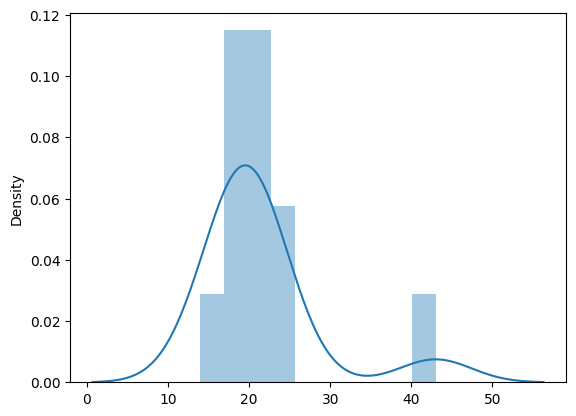

In [18]:
sns.distplot(df1)

C:\Users\ian-g\AppData\Local\Temp\ipykernel_10980\447768823.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2)


<Axes: ylabel='Density'>

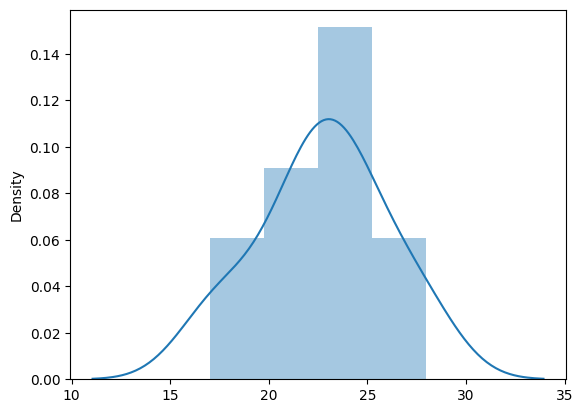

In [22]:
sns.distplot(df2)

In [9]:
#Condições Paramétricas
#1. Amostrar independentes
#Tira uma amostra e isso não impacta nas outras

#2. Normalmente distribuidos - df1 não passa no teste de normalidade
###Teste de Normalidade - Shapiro
#H1: Distribuição não normal (Rejeitanto a hipótese nula, pode ter qualquer outra distribuição)
#H0: Distribuição normalmente distribuída (Toda a mostra tende a ser uma normal, mesmo se a distribuição da população não for normal)
statstic1,p_value1 = shapiro(df1)
print(f'p-value do df1: {p_value1}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição de df1 é normal')

statstic2,p_value2 = shapiro(df2)
print(f'\np-value do df2: {p_value2}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição de df2 é normal')

#3. Variâncias iguais - Não são iguais
print(f'\nVar df1: {np.var(df1)}')
print(f'Var df2: {np.var(df2)}')
#Se dividir a maior variância pela menor e der menor que 4, podemos considerar as variâncias iguais

p-value do df1: 0.0005459145557629783
Falha em rejeitar a hipótese nula, então a distribuição de df1 é normal

p-value do df2: 0.90215082763698
Falha em rejeitar a hipótese nula, então a distribuição de df2 é normal

Var df1: 48.743055555555564
Var df2: 9.6875


In [12]:
m_stats,m_p_value = mannwhitneyu(df1, df2)
print(f'p-value: {m_p_value}')

alpha = 0.05
if m_p_value < alpha:
  print(f'Rejeita a hipótese nula, em favor da hipótese alternativa')
else:
  print(f'Falha em rejeitar a hipótese nula (Assume a hipótese nula)')

#Com o tamanho da amostra e o efeito apresentado eu não posso afirmar que uma planta é maior que a outra devido ao adubo, assumo então a hipótese nula, onde as médias de alturas delas são iguais
#Ou melhora ou efeito, para que com menos amostrar, consiga ver a difença, ou colhe mais amostras

p-value: 0.07217495133598324
Falha em rejeitar a hipótese nula (Assume a hipótese nula)


## 3.4 

Pesquisadores gostariam de saber se **existe uma diferente entre as médias de 4 grupos** que foram submetidos a tratamentos diferentes

In [23]:
df = pd.DataFrame( {'A': [25, 30, 28, 36, 29],
'B': [45, 55, 29, 56, 40],
'C': [30, 29, 33, 37, 27],
'D': [54, 60, 51, 62, 73] } )
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [26]:
df_melt = pd.melt(df.reset_index(),id_vars=['index'],value_vars=['A','B','C','D'])
df_melt.columns = ['index','treatment','value']
df_melt.head()

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


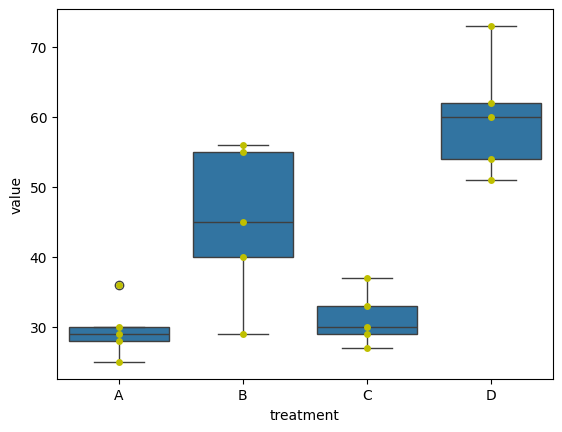

In [30]:
sns.boxplot(x='treatment', y='value',data=df_melt);
sns.swarmplot(x='treatment', y='value',data=df_melt,color='y');
#Para fazer um teste A B é preciso de um planejamento de experimento, principalmente para separação da amostra
#Sem isso, não daria para isolar os efeitos externos

In [45]:
#Condições Paramétricas
#1. Amostrar independentes
#Tira uma amostra e isso não impacta nas outras

#2. Normalmente distribuidos - df1 não passa no teste de normalidade
###Teste de Normalidade - Shapiro
#H1: Distribuição não normal (Rejeitanto a hipótese nula, pode ter qualquer outra distribuição)
#H0: Distribuição normalmente distribuída (Toda a mostra tende a ser uma normal, mesmo se a distribuição da população não for normal)
a_statstic,a_p_value = shapiro(df_melt.loc[df_melt['treatment'] == 'A','value'])
print(f'p-value Grupo A: {a_p_value}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição do Grupo A é normal')

b_statstic,b_p_value = shapiro(df_melt.loc[df_melt['treatment'] == 'B','value'])
print(f'\np-value Grupo B: {b_p_value}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição do Grupo B é normal')

c_statstic,c_p_value = shapiro(df_melt.loc[df_melt['treatment'] == 'C','value'])
print(f'\np-value Grupo C: {c_p_value}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição do Grupo C é normal')

d_statstic,d_p_value = shapiro(df_melt.loc[df_melt['treatment'] == 'D','value'])
print(f'\np-value Grupo D: {d_p_value}')
print(f'Falha em rejeitar a hipótese nula, então a distribuição do Grupo D é normal')


#3. Variâncias iguais - Não são iguais
var_a = np.var(df_melt.loc[df_melt['treatment'] == 'A','value'])
print(f'\nVar A: {var_a}')
var_b = np.var(df_melt.loc[df_melt['treatment'] == 'B','value'])
print(f'Var B: {var_b}')
var_c = np.var(df_melt.loc[df_melt['treatment'] == 'C','value'])
print(f'Var C: {var_c}')
var_d = np.var(df_melt.loc[df_melt['treatment'] == 'D','value'])
print(f'Var D: {var_d}')
#Se dividir a maior variância pela menor e der menor que 4, podemos considerar as variâncias iguais

p-value Grupo A: 0.6075583653996472
Falha em rejeitar a hipótese nula, então a distribuição do Grupo A é normal

p-value Grupo B: 0.5723675006691977
Falha em rejeitar a hipótese nula, então a distribuição do Grupo B é normal

p-value Grupo C: 0.7583121101708065
Falha em rejeitar a hipótese nula, então a distribuição do Grupo C é normal

p-value Grupo D: 0.7002370626370356
Falha em rejeitar a hipótese nula, então a distribuição do Grupo D é normal

Var A: 13.040000000000001
Var B: 100.4
Var C: 12.16
Var D: 58.0


In [49]:
stats,p_value = f_oneway(df_melt.loc[df_melt['treatment'] == 'A','value'],df_melt.loc[df_melt['treatment'] == 'B','value'],df_melt.loc[df_melt['treatment'] == 'C','value'],df_melt.loc[df_melt['treatment'] == 'D','value'])
print(f'p_value: {p_value}')

#H0: Não há diferença nas médias
#H1: Há diferença nas médias

alpha = 0.05
if p_value < alpha:
  print(f'Rejeita a hipótese nula, em favor da hipótese alternativa')
else:
  print(f'Falha em rejeitar a hipótese nula (Assume a hipótese nula)')

p_value: 2.6392411462109217e-05
Rejeita a hipótese nula, em favor da hipótese alternativa


In [54]:
tukey = pairwise_tukeyhsd(endog=df_melt['value'],groups=df_melt['treatment'],alpha=0.05)
print(tukey)
#O único que não posso rejeitar a hipótese nula é entre A e C, nos demais eu consigo dizer que há uma diferença significativa entre as médias

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------


In [ ]:
group1 = [7, 14, 14, 13, 12, 9, 6, 14, 12, 8]
group2 = [15, 17, 13, 15, 15, 13, 9, 12, 10, 8]
group3 = [6, 8, 8, 9, 5, 14, 13, 8, 10, 9]